In [1]:
!pip install bertopic sentence-transformers umap-learn hdbscan scikit-learn pandas numpy nltk matplotlib seaborn Gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 25.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import itertools
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.cluster import KMeans
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

# --- SETUP & STOP WORDS MODIFICATION ---
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Stop words bawaan
stop_words = set(stopwords.words('english'))

# Custom Stop Words untuk BeritaLokalInggris
junk_words_news = {
    # Lokasi & Entitas Umum
    'indonesia', 'surabaya', 'jakarta', 'east', 'java', 'country', 'region',
    'university', 'universitas', 'airlangga', 'unair', 'campus',
    'state', 'national', 'international', 'department', 'faculty', 'school',

    # Media & Atribut Berita
    'jakarta', 'post', 'tempo', 'antara', 'news', 'report', 'reported', 'article',
    'source', 'published', 'media', 'press', 'release', 'page', 'website',
    'photo', 'image', 'caption', 'download', 'app', 'link', 'click', 'read',
    'copyright', 'reserved', 'rights', 'collaboration', 'foundation',

    # Kata Kerja/Keterangan Jurnalistik
    'said', 'says', 'saying', 'told', 'added', 'according', 'statement',
    'also', 'would', 'could', 'since', 'first', 'last', 'next', 'many', 'much',
    'year', 'month', 'week', 'day', 'today', 'yesterday', 'tomorrow', 'time',
    'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
    'percent', 'million', 'billion', 'number', 'total', 'average',

    # Gelar & Sapaan
    'prof', 'dr', 'mr', 'mrs', 'general', 'director', 'manager', 'head', 'chief',
    'executive', 'secretary', 'minister', 'ministry', 'rector', 'dean',
    'expert', 'lecturer', 'researcher', 'student', 'alumni'
}

stop_words.update(junk_words_news)
lemmatizer = WordNetLemmatizer()

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [3]:
# --- DATA LOADING & PREPROCESSING ---
def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'[^a-zA-Z\s]', ' ', str(text).lower())
    text = re.sub(r'\s+', ' ', text).strip()
    words = text.split()
    clean_words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words and len(w) > 2]
    return " ".join(clean_words)

try:
    import chardet

    # Detect encoding
    with open('/content/BeritaLokalInggris.csv', 'rb') as f:
        enc = chardet.detect(f.read())['encoding']
        print("Detected encoding:", enc)

    # Load data with detected encoding
    df = pd.read_csv(
        '/content/BeritaLokalInggris.csv',
        sep=';',
        on_bad_lines='skip',
        encoding=enc
    )

    # Clean & preprocess
    if 'Isi' not in df.columns:
        text_col = df.select_dtypes(include=['object']).columns[-1]
        print(f"Warning: Kolom 'Isi' tidak ditemukan. Menggunakan kolom '{text_col}'")
        df.rename(columns={text_col: 'Isi'}, inplace=True)

    df['clean_content'] = df['Isi'].apply(clean_text)
    df = df[df['clean_content'].str.len() > 10].reset_index(drop=True)

    # Data structures for modeling
    docs = df['clean_content'].tolist()
    tokens = [doc.split() for doc in docs]
    dictionary = corpora.Dictionary(tokens)
    dictionary.filter_extremes(no_below=2, no_above=0.9)
    corpus = [dictionary.doc2bow(token) for token in tokens]

    print(f"Data berhasil dimuat. Jumlah dokumen valid: {len(df)}")

except Exception as e:
    print(f"Error loading data: {e}")

Detected encoding: MacRoman
Data berhasil dimuat. Jumlah dokumen valid: 81


In [4]:
# --- GENERATING EMBEDDINGS ---
print("--- Generating Embeddings ---")
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

# Helper functions untuk evaluasi di sel berikutnya
def calculate_coherence(topic_words_list, texts, dictionary, coherence_type='c_v'):
    if not topic_words_list: return 0.0
    try:
        cm = CoherenceModel(topics=topic_words_list, texts=texts, dictionary=dictionary, coherence=coherence_type)
        return cm.get_coherence()
    except Exception as e:
        print(f"Error: {e}")
        return 0.0

def get_sklearn_topic_words(model, feature_names, n_top_words=10):
    topic_words_list = []
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        topic_words_list.append([feature_names[i] for i in top_indices])
    return topic_words_list

# List untuk menyimpan skor semua model
all_scores = []

--- Generating Embeddings ---


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
# --- 3. OPTIMASI BERTOPIC (Grid Search) ---
print("\n--- Memulai Tuning BERTopic (Ini mungkin memakan waktu) ---")

# Embedding Model (Tetap yang ringan tapi efektif)
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(docs, show_progress_bar=False)

# Grid Parameter
# n_neighbors: 3-5 (fokus mikro untuk data kecil), 10-15 (fokus makro)
# min_cluster_size: 2-3 (biarkan topik kecil muncul), 5 (topik lebih umum)
params = list(itertools.product([3, 5, 10], [2, 3, 5]))

best_score = -1
best_model = None
best_params = {}
results = []

for n_neighbors, min_cluster in params:
    try:
        # 1. UMAP (Dimensi Reduksi)
        umap_model = UMAP(n_neighbors=n_neighbors, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

        # 2. HDBSCAN (Clustering)
        hdbscan_model = HDBSCAN(min_cluster_size=min_cluster, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

        # 3. Vectorizer (KUNCI PERBAIKAN: N-GRAMS)
        # ngram_range=(1, 2) akan menangkap "sexual harassment" sebagai satu kesatuan
        vectorizer_model = CountVectorizer(stop_words=list(stop_words), min_df=2, ngram_range=(1, 2))

        # Train Model
        topic_model = BERTopic(
            embedding_model=embedding_model,
            umap_model=umap_model,
            hdbscan_model=hdbscan_model,
            vectorizer_model=vectorizer_model,
            verbose=False
        )
        topics, probs = topic_model.fit_transform(docs, embeddings)

        # 4. OUTLIER REDUCTION (KUNCI PERBAIKAN UNTUK DATA KECIL)
        # Memaksa dokumen -1 masuk ke topik terdekat
        new_topics = topic_model.reduce_outliers(docs, topics)
        topic_model.update_topics(docs, topics=new_topics)

        # Evaluasi
        topic_info = topic_model.get_topic_info()
        valid_topics = topic_info[topic_info['Topic'] != -1]['Topic'].tolist()

        if not valid_topics: continue

        topic_words = []
        for t in valid_topics:
            words = [w[0] for w in topic_model.get_topic(t)[:10]]
            topic_words.append(words)

        # Hitung Coherence
        cm = CoherenceModel(topics=topic_words, texts=tokens, dictionary=dictionary, coherence='c_v')
        score = cm.get_coherence()

        results.append({'n_neighbors': n_neighbors, 'min_cluster': min_cluster, 'Coherence': score})

        # Simpan yang terbaik
        if score > best_score:
            best_score = score
            best_model = topic_model
            best_params = {'n_neighbors': n_neighbors, 'min_cluster': min_cluster}
            print(f"  > New Best! Params: {best_params} | Score: {score:.4f}")

    except Exception as e:
        continue

# Add BERTopic's best score to all_scores
if best_model:
    all_scores.append({'Model': 'BERTopic', 'Coherence': best_score})


# --- 4. HASIL AKHIR ---
print("\n" + "="*40)
print(f"JUARA BERTOPIC: Coherence {best_score:.4f}")
print(f"Parameter: {best_params}")
print("="*40)

if best_model:
    print("\nTopik yang Ditemukan:")
    print(best_model.get_topic_info().head(10)[['Topic', 'Count', 'Name', 'Representation']])

    # Visualisasi Jarak Antar Topik
    try:
        fig = best_model.visualize_topics()
        fig.show()
    except:
        print("Visualisasi interaktif tidak dapat ditampilkan di environment ini.")


--- Memulai Tuning BERTopic (Ini mungkin memakan waktu) ---


2025-12-09 16:37:16,784 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


  > New Best! Params: {'n_neighbors': 3, 'min_cluster': 2} | Score: 0.5644


2025-12-09 16:37:17,497 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-12-09 16:37:18,038 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.
2025-12-09 16:37:19,361 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF em

  > New Best! Params: {'n_neighbors': 10, 'min_cluster': 2} | Score: 0.5766


2025-12-09 16:37:20,037 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


  > New Best! Params: {'n_neighbors': 10, 'min_cluster': 3} | Score: 0.6119


2025-12-09 16:37:20,637 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.



JUARA BERTOPIC: Coherence 0.6119
Parameter: {'n_neighbors': 10, 'min_cluster': 3}

Topik yang Ditemukan:
   Topic  Count                                Name  \
0      0     35  0_political_people_social_economic   
1      1     33        1_covid_vaccine_test_patient   
2      2      7        2_gilang_victim_child_sexual   
3      3      6       3_doctor_foreign_medical_budi   

                                      Representation  
0  [political, people, social, economic, indonesi...  
1  [covid, vaccine, test, patient, government, he...  
2  [gilang, victim, child, sexual, police, family...  
3  [doctor, foreign, medical, budi, health, plan,...  


In [6]:
print("\n--- Running K-Means ---")
# Reduce dimensions for K-Means
umap_KM = UMAP(n_neighbors=5, n_components=10, min_dist=0.0, metric='cosine', random_state=42)
reduced_embeddings = umap_KM.fit_transform(embeddings)

kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
clusters = kmeans.fit_predict(reduced_embeddings)
df['kmeans_cluster'] = clusters

# Extract keywords using TF-IDF per cluster
tfidf_km = TfidfVectorizer(stop_words=list(stop_words), max_df=0.9, min_df=2)
tfidf_km.fit(df['clean_content'])
features_km = tfidf_km.get_feature_names_out()

kmeans_topic_words = []
for i in range(5):
    cluster_docs = df[df['kmeans_cluster'] == i]['clean_content']
    if len(cluster_docs) == 0: continue
    cluster_tfidf = tfidf_km.transform(cluster_docs)
    mean_tfidf = np.array(cluster_tfidf.mean(axis=0)).flatten()
    top_indices = mean_tfidf.argsort()[:-11:-1]
    kmeans_topic_words.append([features_km[ind] for ind in top_indices])

cm = CoherenceModel(topics=kmeans_topic_words, texts=tokens, dictionary=dictionary, coherence='c_v')
score_kmeans = cm.get_coherence() # Renamed 'score' to 'score_kmeans' for clarity
all_scores.append({'Model': 'K-Means', 'Coherence': score_kmeans})
print(f"K-Means Coherence: {score_kmeans:.4f}")


--- Running K-Means ---
K-Means Coherence: 0.6615


In [7]:
print("\n--- Running NMF, LDA, LSA ---")
n_topics = 5

# TF-IDF for NMF & LSA
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=2, stop_words=list(stop_words))
tfidf_matrix = tfidf_vectorizer.fit_transform(docs)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

# Count Vectorizer for LDA
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=2, stop_words=list(stop_words))
tf_matrix = tf_vectorizer.fit_transform(docs)
tf_feature_names = tf_vectorizer.get_feature_names_out()

# 1. NMF
nmf = NMF(n_components=n_topics, random_state=42, init='nndsvd').fit(tfidf_matrix)
nmf_words = get_sklearn_topic_words(nmf, tfidf_feature_names)
score_nmf = calculate_coherence(nmf_words, tokens, dictionary)
all_scores.append({'Model': 'NMF', 'Coherence': score_nmf})
print(f"NMF Coherence: {score_nmf:.4f}")

# 2. LSA
lsa = TruncatedSVD(n_components=n_topics, random_state=42).fit(tfidf_matrix)
lsa_words = get_sklearn_topic_words(lsa, tfidf_feature_names)
score_lsa = calculate_coherence(lsa_words, tokens, dictionary)
all_scores.append({'Model': 'LSA', 'Coherence': score_lsa})
print(f"LSA Coherence: {score_lsa:.4f}")

# 3. LDA
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_method='online').fit(tf_matrix)
lda_words = get_sklearn_topic_words(lda, tf_feature_names)
score_lda = calculate_coherence(lda_words, tokens, dictionary)
all_scores.append({'Model': 'LDA', 'Coherence': score_lda})
print(f"LDA Coherence: {score_lda:.4f}")


--- Running NMF, LDA, LSA ---
NMF Coherence: 0.6664
LSA Coherence: 0.6055
LDA Coherence: 0.3231



=== FINAL RESULTS (Ranked by Coherence Score) ===
      Model  Coherence
2       NMF   0.666444
1   K-Means   0.661529
0  BERTopic   0.611929
3       LSA   0.605511
4       LDA   0.323122


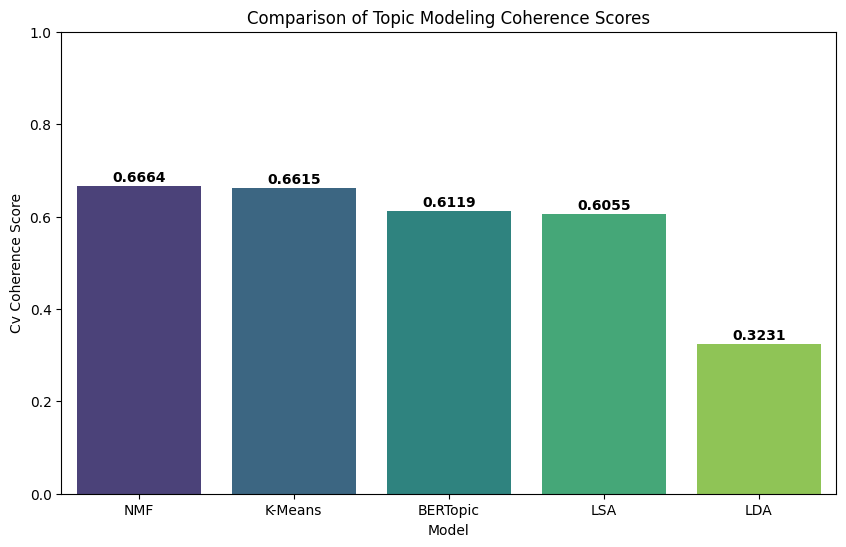


Topik dari Model Terbaik (NMF):
Topic 0: economic, digital, political, government, attack, social, indonesian, korea, people, south
Topic 1: vaccine, trial, covid, clinical, research, candidate, mrna, drug, production, phase
Topic 2: gilang, victim, sexual, police, fikris, thesis, wrapping, body, case, defendant
Topic 3: doctor, foreign, medical, budi, plan, dismissal, health, santoso, academic, freedom
Topic 4: test, covid, lab, patient, pcr, virus, robot, health, kit, sample


In [8]:
# --- FINAL COMPARISON & VISUALIZATION ---
results_df = pd.DataFrame(all_scores).sort_values(by='Coherence', ascending=False)

print("\n=== FINAL RESULTS (Ranked by Coherence Score) ===")
print(results_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='Coherence', palette='viridis')
plt.title('Comparison of Topic Modeling Coherence Scores')
plt.ylabel('Cv Coherence Score')
plt.ylim(0, 1.0)
for i, v in enumerate(results_df['Coherence']):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold')
plt.show()

# --- PRINT TOP WORDS FOR BEST MODEL ---
best_model_name = results_df.iloc[0]['Model']
print(f"\nTopik dari Model Terbaik ({best_model_name}):")

if best_model_name == 'BERTopic':
    if best_bertopic_model:
        print(best_bertopic_model.get_topic_info().head(6)[['Topic', 'Count', 'Name', 'Representation']])
elif best_model_name == 'K-Means':
    for i, words in enumerate(kmeans_topic_words):
        print(f"Cluster {i}: {', '.join(words)}")
elif best_model_name == 'NMF':
    for i, words in enumerate(nmf_words):
        print(f"Topic {i}: {', '.join(words)}")
elif best_model_name == 'LSA':
    for i, words in enumerate(lsa_words):
        print(f"Topic {i}: {', '.join(words)}")
elif best_model_name == 'LDA':
    for i, words in enumerate(lda_words):
        print(f"Topic {i}: {', '.join(words)}")

In [9]:
print("Installing wordcloud library...")
!pip install wordcloud
print("Wordcloud library installed.")

Installing wordcloud library...
Wordcloud library installed.


In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(word_list, title):
    """
    Generates and displays a word cloud from a list of words.

    Args:
        word_list (list): A list of words to include in the word cloud.
        title (str): The title for the word cloud plot.
    """
    # Convert the list of words into a single string
    text = " ".join(word_list)

    # Initialize WordCloud object with specified parameters
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50).generate(text)

    # Display the generated image:
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=15)
    plt.axis('off')
    plt.show()

print("Defined create_wordcloud function.")

Defined create_wordcloud function.



--- Generating Word Clouds for NMF Topics ---
Generating word cloud for NMF Topic 0 Word Cloud...


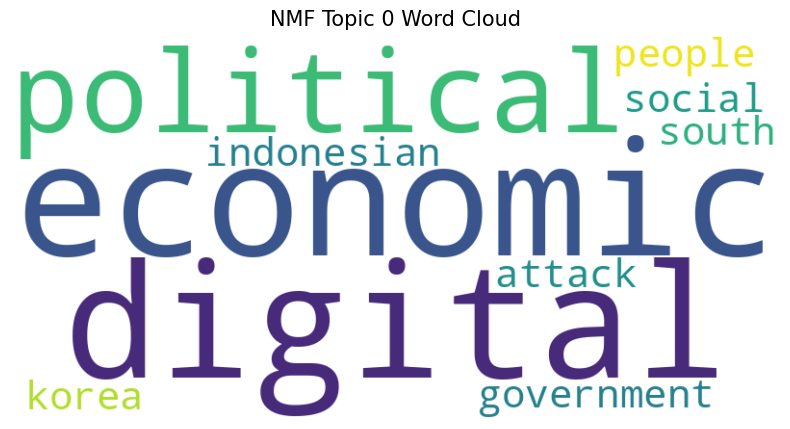

Generating word cloud for NMF Topic 1 Word Cloud...


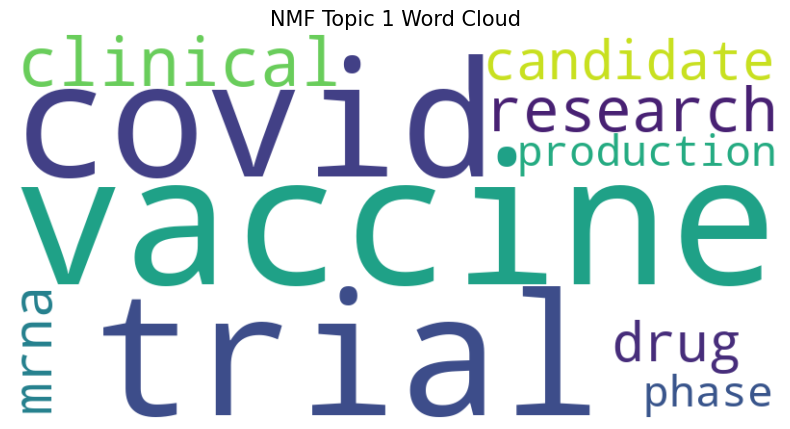

Generating word cloud for NMF Topic 2 Word Cloud...


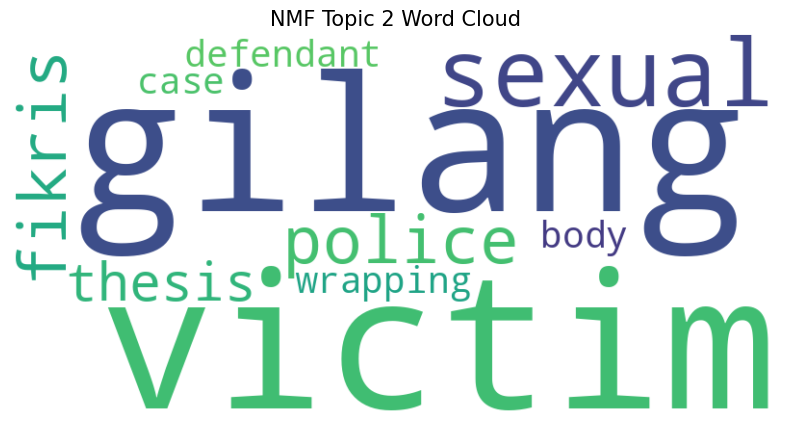

Generating word cloud for NMF Topic 3 Word Cloud...


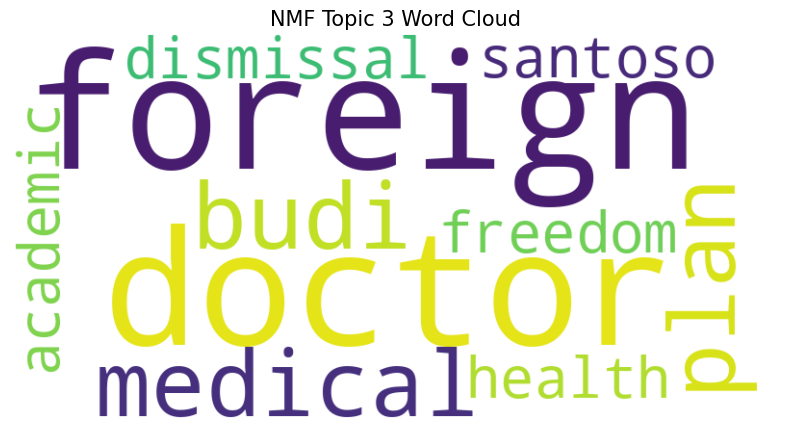

Generating word cloud for NMF Topic 4 Word Cloud...


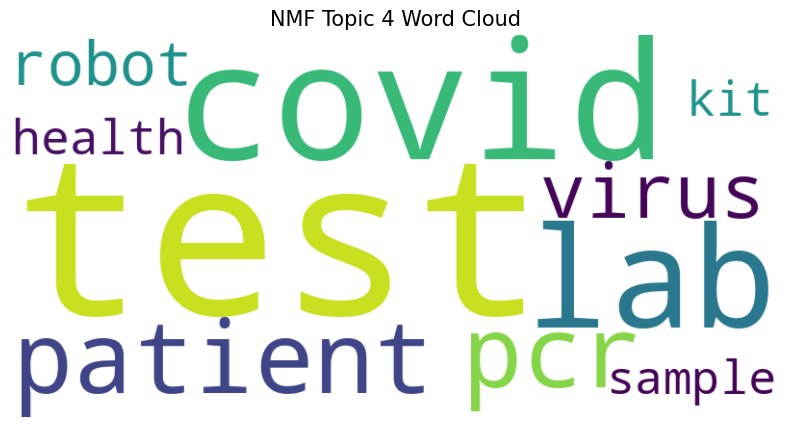

In [11]:
print("\n--- Generating Word Clouds for NMF Topics ---")

# Accessing nmf_words from the kernel state
# nmf_words was defined in a previous cell and contains the top words for each NMF topic

if 'nmf_words' in locals() or 'nmf_words' in globals():
    for i, words in enumerate(nmf_words):
        title = f"NMF Topic {i} Word Cloud"
        print(f"Generating word cloud for {title}...")
        create_wordcloud(words, title)
else:
    print("Error: nmf_words not found. Please ensure NMF model was run successfully.")



--- Generating Word Clouds for BERTopic Topics ---
Generating word cloud for BERTopic Topic 0 Word Cloud...


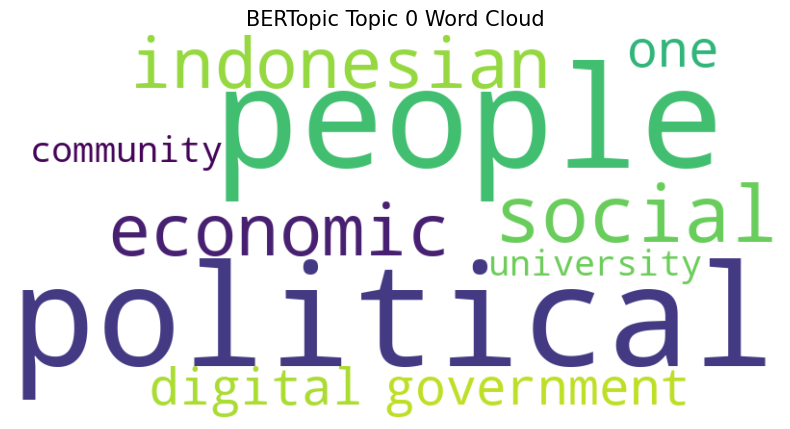

Generating word cloud for BERTopic Topic 1 Word Cloud...


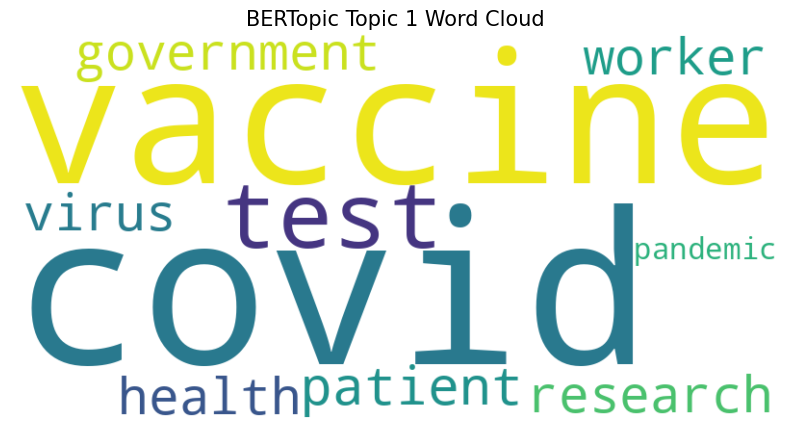

Generating word cloud for BERTopic Topic 2 Word Cloud...


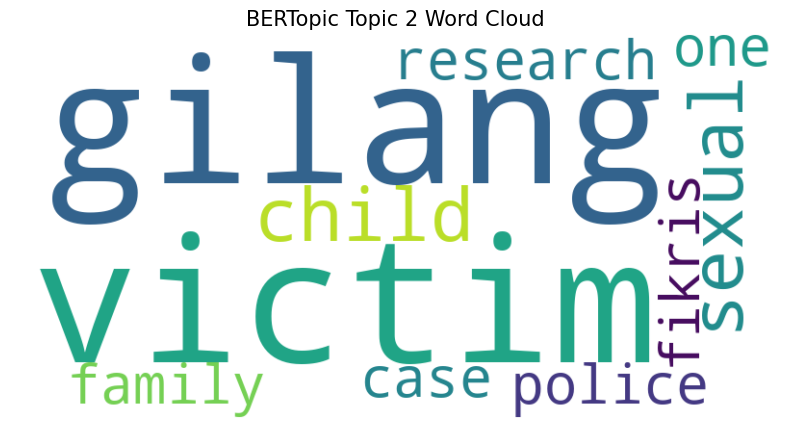

Generating word cloud for BERTopic Topic 3 Word Cloud...


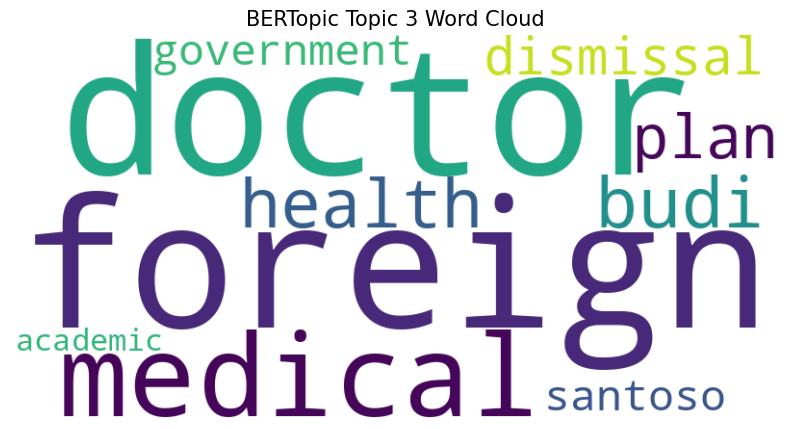

In [12]:
print("\n--- Generating Word Clouds for BERTopic Topics ---")

# Check if best_model (BERTopic) exists
if 'best_model' in locals() and best_model is not None:
    topic_info_bertopic = best_model.get_topic_info()
    # Filter out the outlier topic (-1)
    valid_topics_bertopic = topic_info_bertopic[topic_info_bertopic['Topic'] != -1]['Topic'].tolist()

    if not valid_topics_bertopic:
        print("No valid BERTopic topics found to generate word clouds.")
    else:
        for topic_id in valid_topics_bertopic:
            # Extract top 10 words for the current topic
            words_and_scores = best_model.get_topic(topic_id)
            topic_words = [word for word, score in words_and_scores]

            if topic_words:
                title = f"BERTopic Topic {topic_id} Word Cloud"
                print(f"Generating word cloud for {title}...")
                create_wordcloud(topic_words, title)
            else:
                print(f"No words found for BERTopic Topic {topic_id}.")
else:
    print("Error: BERTopic 'best_model' not found. Please ensure the BERTopic model was run successfully.")



--- Generating Word Clouds for K-Means Topics ---
Generating word cloud for K-Means Cluster 0 Word Cloud...


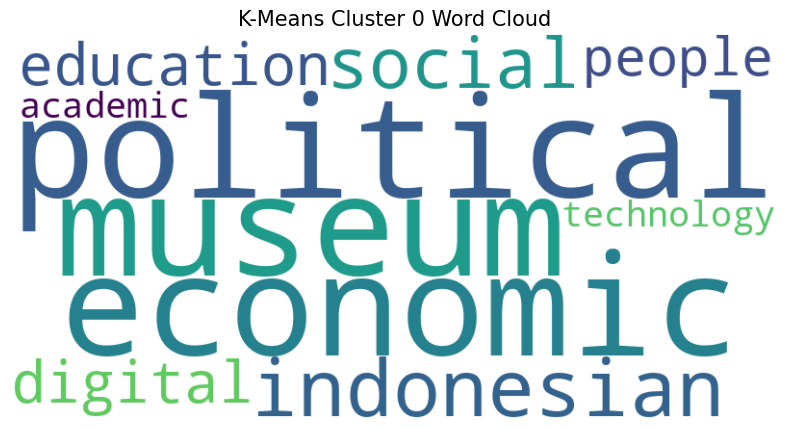

Generating word cloud for K-Means Cluster 1 Word Cloud...


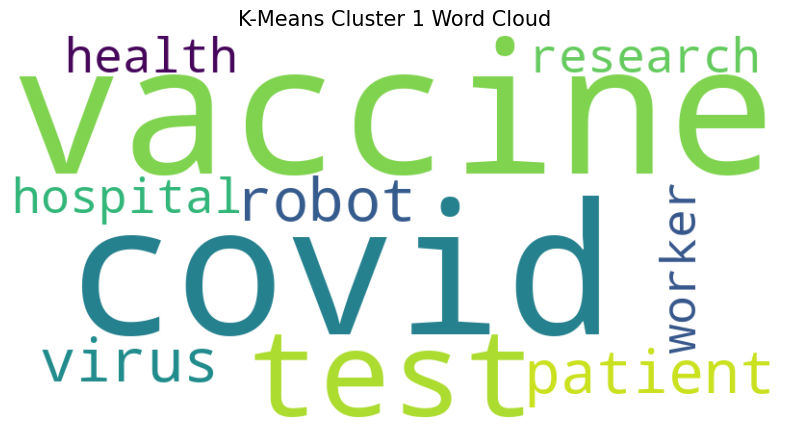

Generating word cloud for K-Means Cluster 2 Word Cloud...


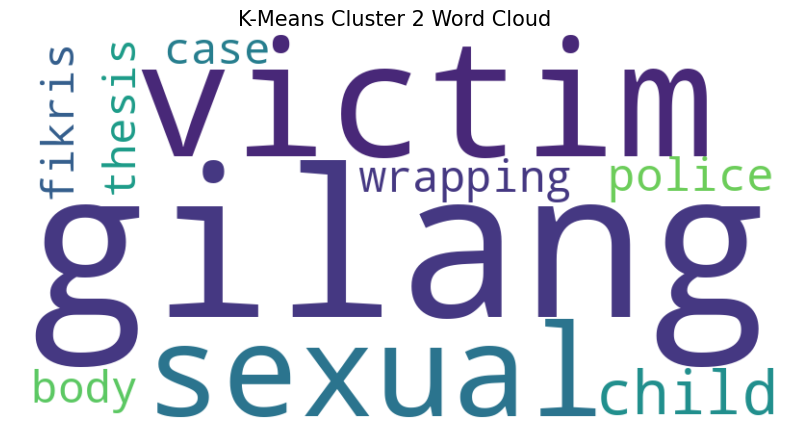

Generating word cloud for K-Means Cluster 3 Word Cloud...


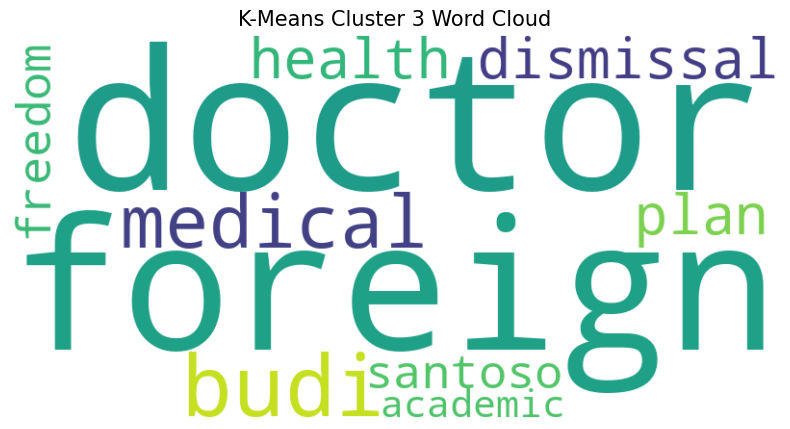

Generating word cloud for K-Means Cluster 4 Word Cloud...


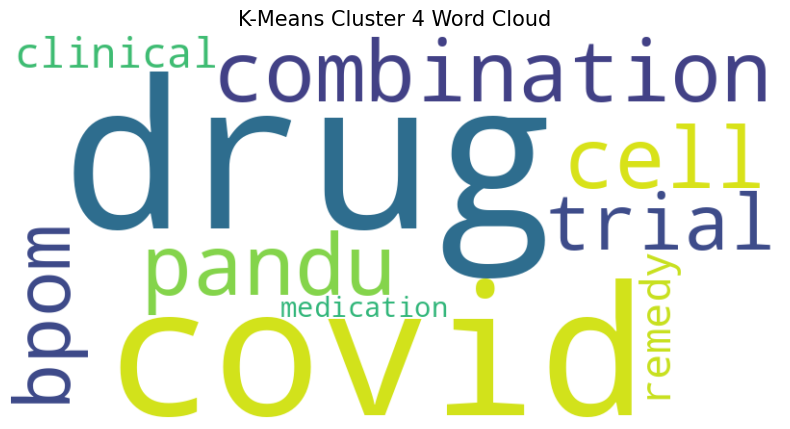

In [13]:
print("\n--- Generating Word Clouds for K-Means Topics ---")

# Accessing kmeans_topic_words from the kernel state
# kmeans_topic_words was defined in a previous cell and contains the top words for each K-Means topic

if 'kmeans_topic_words' in locals() or 'kmeans_topic_words' in globals():
    for i, words in enumerate(kmeans_topic_words):
        title = f"K-Means Cluster {i} Word Cloud"
        print(f"Generating word cloud for {title}...")
        create_wordcloud(words, title)
else:
    print("Error: kmeans_topic_words not found. Please ensure K-Means model was run successfully.")


--- Generating Word Clouds for LSA Topics ---
Generating word cloud for LSA Topic 0 Word Cloud...


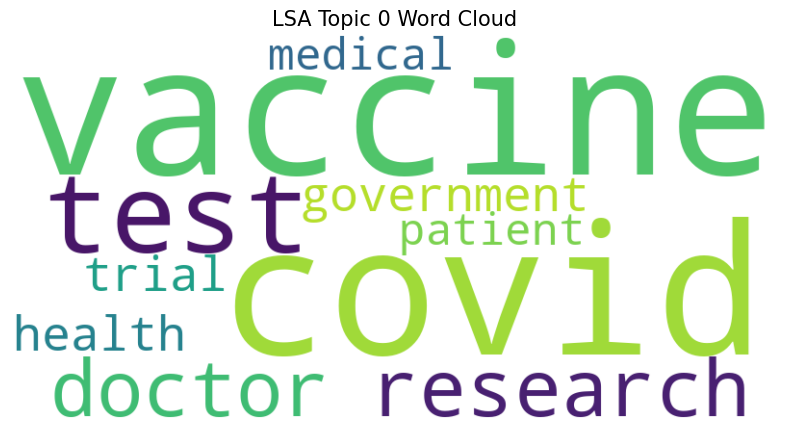

Generating word cloud for LSA Topic 1 Word Cloud...


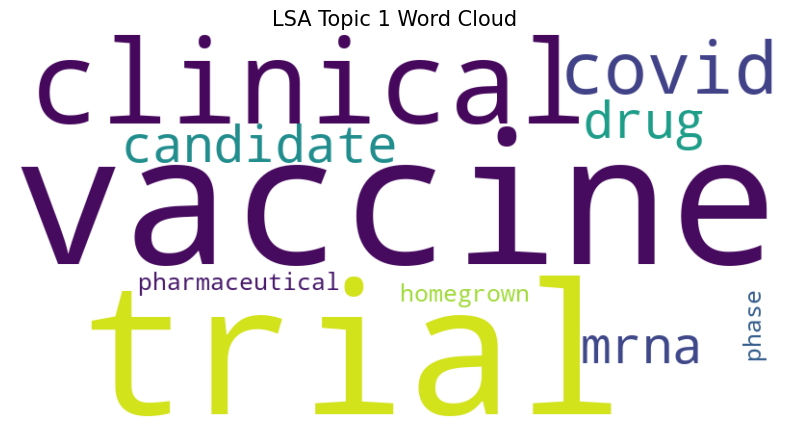

Generating word cloud for LSA Topic 2 Word Cloud...


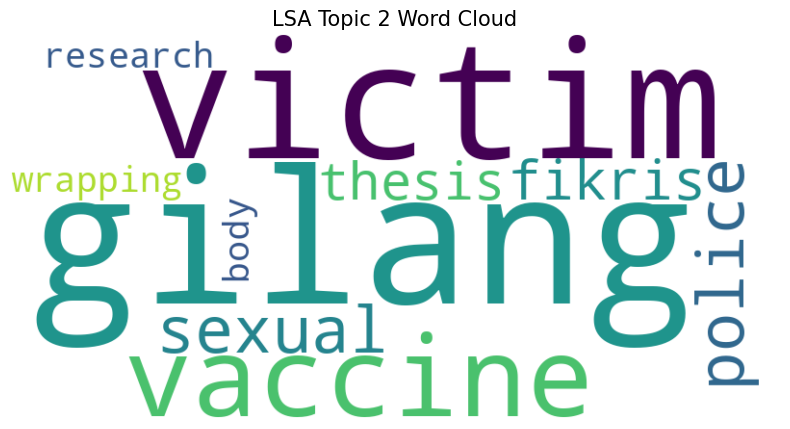

Generating word cloud for LSA Topic 3 Word Cloud...


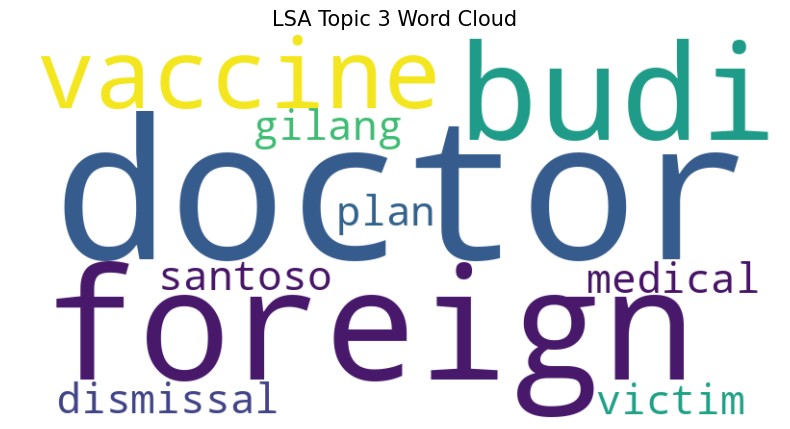

Generating word cloud for LSA Topic 4 Word Cloud...


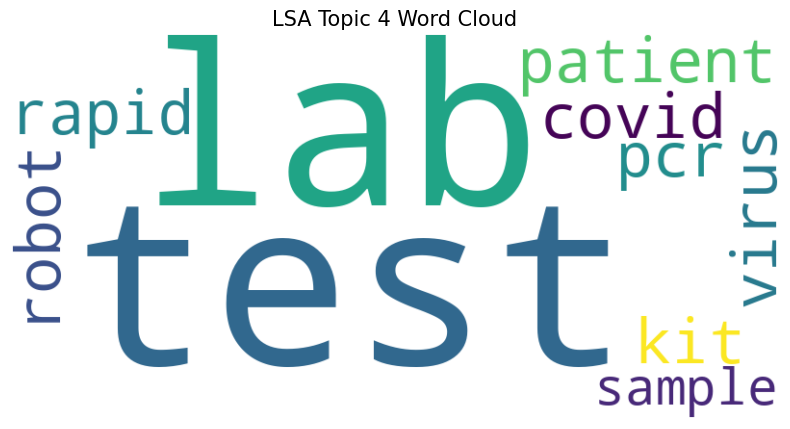

In [14]:
print("\n--- Generating Word Clouds for LSA Topics ---")

# Accessing lsa_words from the kernel state
# lsa_words was defined in a previous cell and contains the top words for each LSA topic

if 'lsa_words' in locals() or 'lsa_words' in globals():
    for i, words in enumerate(lsa_words):
        title = f"LSA Topic {i} Word Cloud"
        print(f"Generating word cloud for {title}...")
        create_wordcloud(words, title)
else:
    print("Error: lsa_words not found. Please ensure LSA model was run successfully.")

In [15]:
import pandas as pd
import numpy as np
import re

# --- FUNGSI PEMBERSIH TAMPILAN ---
def clean_display_text(text, max_len=200):
    if pd.isna(text):
        return ""
    text = str(text).strip()

    # PERBAIKAN: Menghilangkan spasi setelah karakter kapital pertama (Artifact Drop Cap)
    # Contoh: "T he" -> "The", "I ndividuals" -> "Individuals", "A irlangga" -> "Airlangga"
    # Regex ini mencari Huruf Kapital di awal string, diikuti spasi, lalu huruf kecil.
    text = re.sub(r'^([A-Z])\s+([a-z])', r'\1\2', text)

    # Memotong teks jika terlalu panjang
    if len(text) > max_len:
        return text[:max_len] + "..."
    return text

print("=== HASIL TOPIK & REPRESENTASI KALIMAT ASLI (DIRAPIKAN) ===\n")

# ==========================================
# 1. MODEL: BERTopic
# ==========================================
print("\n" + "="*60)
print("1. MODEL: BERTopic")
print("="*60)

if 'best_model' in locals() and best_model is not None:
    topic_info = best_model.get_topic_info()
    try:
        doc_topics = best_model.topics_
    except AttributeError:
        doc_topics, _ = best_model.transform(docs)

    valid_topics = topic_info[topic_info['Topic'] != -1]['Topic'].head(5).tolist()

    for topic_id in valid_topics:
        topic_keywords = [w[0] for w in best_model.get_topic(topic_id)][:10]
        print(f"\n[Topic {topic_id}]")
        print(f"Keywords: {', '.join(topic_keywords)}")

        indices = [i for i, x in enumerate(doc_topics) if x == topic_id]
        if indices:
            print("Contoh Kalimat Asli:")
            for i, idx in enumerate(indices[:3]):
                raw_text = df.iloc[idx]['Isi']
                print(f"  {i+1}. {clean_display_text(raw_text)}")
        else:
            print("  Tidak ada dokumen representatif.")
else:
    print("Model BERTopic belum dijalankan/tersedia.")

# ==========================================
# 2. MODEL: K-Means
# ==========================================
print("\n" + "="*60)
print("2. MODEL: K-Means")
print("="*60)

if 'kmeans' in locals() and 'kmeans_topic_words' in locals():
    for cluster_id, keywords in enumerate(kmeans_topic_words):
        print(f"\n[Cluster {cluster_id}]")
        print(f"Keywords: {', '.join(keywords)}")

        cluster_docs = df[df['kmeans_cluster'] == cluster_id]
        sample_indices = cluster_docs.index[:3]

        print("Contoh Kalimat Asli:")
        for i, idx in enumerate(sample_indices):
            raw_text = df.loc[idx, 'Isi']
            print(f"  {i+1}. {clean_display_text(raw_text)}")
else:
    print("Hasil K-Means belum tersedia.")

# ==========================================
# 3. MODEL: NMF
# ==========================================
print("\n" + "="*60)
print("3. MODEL: NMF")
print("="*60)

if 'nmf' in locals() and 'tfidf_matrix' in locals() and 'nmf_words' in locals():
    nmf_W = nmf.transform(tfidf_matrix)
    for topic_id, keywords in enumerate(nmf_words):
        print(f"\n[Topic {topic_id}]")
        print(f"Keywords: {', '.join(keywords)}")

        top_doc_indices = nmf_W[:, topic_id].argsort()[::-1][:3]
        print("Contoh Kalimat Asli:")
        for i, idx in enumerate(top_doc_indices):
            raw_text = df.iloc[idx]['Isi']
            print(f"  {i+1}. {clean_display_text(raw_text)}")
else:
    print("Hasil NMF belum tersedia.")

# ==========================================
# 4. MODEL: LDA
# ==========================================
print("\n" + "="*60)
print("4. MODEL: LDA")
print("="*60)

if 'lda' in locals() and 'tf_matrix' in locals() and 'lda_words' in locals():
    lda_W = lda.transform(tf_matrix)
    for topic_id, keywords in enumerate(lda_words):
        print(f"\n[Topic {topic_id}]")
        print(f"Keywords: {', '.join(keywords)}")

        top_doc_indices = lda_W[:, topic_id].argsort()[::-1][:3]
        print("Contoh Kalimat Asli:")
        for i, idx in enumerate(top_doc_indices):
            raw_text = df.iloc[idx]['Isi']
            print(f"  {i+1}. {clean_display_text(raw_text)}")
else:
    print("Hasil LDA belum tersedia.")

# ==========================================
# 5. MODEL: LSA
# ==========================================
print("\n" + "="*60)
print("5. MODEL: LSA")
print("="*60)

if 'lsa' in locals() and 'tfidf_matrix' in locals() and 'lsa_words' in locals():
    lsa_W = lsa.transform(tfidf_matrix)
    for topic_id, keywords in enumerate(lsa_words):
        print(f"\n[Topic {topic_id}]")
        print(f"Keywords: {', '.join(keywords)}")

        top_doc_indices = lsa_W[:, topic_id].argsort()[::-1][:3]
        print("Contoh Kalimat Asli:")
        for i, idx in enumerate(top_doc_indices):
            raw_text = df.iloc[idx]['Isi']
            print(f"  {i+1}. {clean_display_text(raw_text)}")
else:
    print("Hasil LSA belum tersedia.")

=== HASIL TOPIK & REPRESENTASI KALIMAT ASLI (DIRAPIKAN) ===


1. MODEL: BERTopic

[Topic 0]
Keywords: political, people, social, economic, indonesian, digital, government, one, university, community
Contoh Kalimat Asli:
  1. Indonesia and South Korea have maintained bilateral ties for more than 50 years, with relentless efforts conducted to spur close bilateral relationship, especially in economics, trade and investment. ...
  2. Bilateral cooperation between Indonesia and South Korea has been established for over 50 years. The close relationship between the two countries continues to be promoted, especially in the sectors of ...
  3. Amuseum in the East Java city of Surabaya aims to enlighten people about Indonesian funeral rituals and their correlation to other fields, including the economy and culture. The†Ethnography Museum and...

[Topic 1]
Keywords: covid, vaccine, test, patient, government, health, virus, research, worker, pandemic
Contoh Kalimat Asli:
  1. Airlangga University 

# Task
Perform a grid search to optimize the number of topics (k from 2 to 15) for K-Means, NMF, LSA, and LDA models, calculating and storing the C_v coherence score for each configuration. Then, generate a line plot visualizing the coherence scores against the number of topics for these models. Finally, compare the best coherence scores across all models (including BERTopic) using a bar chart and display the top words for the overall best-performing model.

## Perform Grid Search for K-Means, NMF, LSA, and LDA

### Subtask:
Iterate through a range of topic numbers (k from 2 to 15) for K-Means, NMF, LSA, and LDA models. For each 'k', train the respective topic model, calculate its C_v coherence score, and store the model name, 'k' value, and coherence score. Keep track of the best 'k' and its coherence score for each model. Finally, update the `all_scores` list with the highest coherence found for each model.


**Reasoning**:
The subtask requires performing a grid search for K-Means, NMF, LSA, and LDA models to find the optimal number of topics (k) based on coherence scores. This code block initializes variables, iterates through k from 2 to 15 for each model, trains the model, calculates coherence, tracks the best k and score, and finally updates the 'all_scores' list with the best coherence for each model.



In [16]:
print("\n--- Performing Grid Search for K-Means, NMF, LSA, and LDA ---")

k_range = range(2, 16) # k from 2 to 15

# 1. Initialize variables
# For K-Means
kmeans_coherence_per_k = []
best_kmeans_score = -1
best_k_kmeans = -1
best_kmeans_model_for_display = None # To store the best model for later keyword extraction

# For NMF
nmf_coherence_per_k = []
best_nmf_score = -1
best_k_nmf = -1
best_nmf_model_for_display = None

# For LSA
lsa_coherence_per_k = []
best_lsa_score = -1
best_k_lsa = -1
best_lsa_model_for_display = None

# For LDA
lda_coherence_per_k = []
best_lda_score = -1
best_k_lda = -1
best_lda_model_for_display = None

# --- Grid Search for K-Means ---
print("\nRunning Grid Search for K-Means...")
for k in k_range:
    try:
        # Ensure reduced_embeddings is available and correctly calculated for K-Means
        # (It was already calculated in cell '51zxLAcjqzkr')
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(reduced_embeddings)

        current_kmeans_topic_words = []
        for i in range(k):
            cluster_docs_indices = df.index[clusters == i]
            if len(cluster_docs_indices) == 0: # Skip empty clusters
                continue
            cluster_docs_content = df.loc[cluster_docs_indices, 'clean_content']

            # Handle cases where cluster_docs_content might be empty or problematic
            if len(cluster_docs_content) > 0:
                cluster_tfidf = tfidf_km.transform(cluster_docs_content)
                # Check if cluster_tfidf has any data after transformation
                if cluster_tfidf.shape[0] > 0:
                    mean_tfidf = np.array(cluster_tfidf.mean(axis=0)).flatten()
                    # Ensure enough features exist for 10 words
                    n_top_words = min(10, len(features_km))
                    top_indices = mean_tfidf.argsort()[:-n_top_words - 1:-1]
                    current_kmeans_topic_words.append([features_km[ind] for ind in top_indices])

        if not current_kmeans_topic_words: # If no topic words were extracted, skip coherence calculation
            continue

        score = calculate_coherence(current_kmeans_topic_words, tokens, dictionary, coherence_type='c_v')
        kmeans_coherence_per_k.append({'k': k, 'coherence': score})

        if score > best_kmeans_score:
            best_kmeans_score = score
            best_k_kmeans = k
            # We don't store the full KMeans model, but ensure we can recreate keywords later if needed.

    except Exception as e:
        print(f"Error in K-Means for k={k}: {e}")

# --- Grid Search for NMF ---
print("Running Grid Search for NMF...")
for k in k_range:
    try:
        nmf = NMF(n_components=k, random_state=42, init='nndsvd')
        nmf.fit(tfidf_matrix)
        current_nmf_words = get_sklearn_topic_words(nmf, tfidf_feature_names)
        score = calculate_coherence(current_nmf_words, tokens, dictionary, coherence_type='c_v')
        nmf_coherence_per_k.append({'k': k, 'coherence': score})

        if score > best_nmf_score:
            best_nmf_score = score
            best_k_nmf = k
            best_nmf_model_for_display = nmf # Store the best model

    except Exception as e:
        print(f"Error in NMF for k={k}: {e}")

# --- Grid Search for LSA ---
print("Running Grid Search for LSA...")
for k in k_range:
    try:
        lsa = TruncatedSVD(n_components=k, random_state=42)
        lsa.fit(tfidf_matrix)
        current_lsa_words = get_sklearn_topic_words(lsa, tfidf_feature_names)
        score = calculate_coherence(current_lsa_words, tokens, dictionary, coherence_type='c_v')
        lsa_coherence_per_k.append({'k': k, 'coherence': score})

        if score > best_lsa_score:
            best_lsa_score = score
            best_k_lsa = k
            best_lsa_model_for_display = lsa # Store the best model

    except Exception as e:
        print(f"Error in LSA for k={k}: {e}")

# --- Grid Search for LDA ---
print("Running Grid Search for LDA...")
for k in k_range:
    try:
        lda = LatentDirichletAllocation(n_components=k, random_state=42, learning_method='online')
        lda.fit(tf_matrix)
        current_lda_words = get_sklearn_topic_words(lda, tf_feature_names)
        score = calculate_coherence(current_lda_words, tokens, dictionary, coherence_type='c_v')
        lda_coherence_per_k.append({'k': k, 'coherence': score})

        if score > best_lda_score:
            best_lda_score = score
            best_k_lda = k
            best_lda_model_for_display = lda # Store the best model

    except Exception as e:
        print(f"Error in LDA for k={k}: {e}")

# --- Update all_scores with the best results ---
all_scores = [] # Clear previous scores to only include the best k

# Add BERTopic's best score (if available from previous cell)
# Assuming best_score and best_params for BERTopic are still in scope.
# If BERTopic was run and produced a best_score:
if 'best_score' in globals() and best_score is not None and best_score > -1:
    all_scores.append({'Model': 'BERTopic', 'Coherence': best_score})
else:
    print("BERTopic's best score not found or invalid.")

if best_kmeans_score > -1:
    all_scores.append({'Model': 'K-Means', 'Coherence': best_kmeans_score})
    print(f"Best K-Means: k={best_k_kmeans}, Coherence={best_kmeans_score:.4f}")
if best_nmf_score > -1:
    all_scores.append({'Model': 'NMF', 'Coherence': best_nmf_score})
    print(f"Best NMF: k={best_k_nmf}, Coherence={best_nmf_score:.4f}")
if best_lsa_score > -1:
    all_scores.append({'Model': 'LSA', 'Coherence': best_lsa_score})
    print(f"Best LSA: k={best_k_lsa}, Coherence={best_lsa_score:.4f}")
if best_lda_score > -1:
    all_scores.append({'Model': 'LDA', 'Coherence': best_lda_score})
    print(f"Best LDA: k={best_k_lda}, Coherence={best_lda_score:.4f}")

print("Grid search complete. all_scores updated.")


--- Performing Grid Search for K-Means, NMF, LSA, and LDA ---

Running Grid Search for K-Means...
Running Grid Search for NMF...
Running Grid Search for LSA...
Running Grid Search for LDA...
Best K-Means: k=5, Coherence=0.6615
Best NMF: k=9, Coherence=0.7472
Best LSA: k=2, Coherence=0.6596
Best LDA: k=10, Coherence=0.5142
Grid search complete. all_scores updated.


**Reasoning**:
The previous step completed the grid search for optimal `k` values for K-Means, NMF, LSA, and LDA models and updated `all_scores`. The next instruction in the overall task is to generate a line plot visualizing the coherence scores against the number of topics for these models. This command will retrieve the stored coherence scores per `k` and plot them.




--- Visualizing Coherence Scores vs. Number of Topics (k) ---


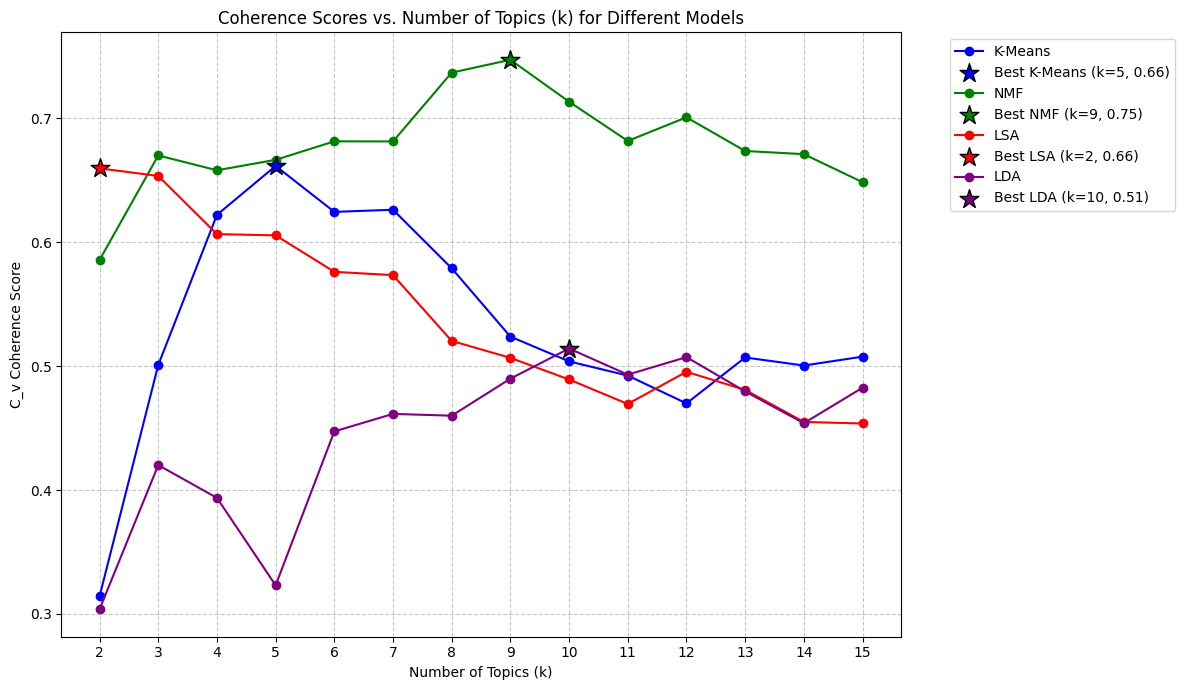

In [17]:
print("\n--- Visualizing Coherence Scores vs. Number of Topics (k) ---")

plt.figure(figsize=(12, 7))

# Plot K-Means
if kmeans_coherence_per_k:
    k_values = [res['k'] for res in kmeans_coherence_per_k]
    coherence_scores = [res['coherence'] for res in kmeans_coherence_per_k]
    plt.plot(k_values, coherence_scores, marker='o', label='K-Means', color='blue')
    plt.scatter(best_k_kmeans, best_kmeans_score, marker='*', s=200, color='blue', edgecolor='black', zorder=5, label=f'Best K-Means (k={best_k_kmeans:.0f}, {best_kmeans_score:.2f})')

# Plot NMF
if nmf_coherence_per_k:
    k_values = [res['k'] for res in nmf_coherence_per_k]
    coherence_scores = [res['coherence'] for res in nmf_coherence_per_k]
    plt.plot(k_values, coherence_scores, marker='o', label='NMF', color='green')
    plt.scatter(best_k_nmf, best_nmf_score, marker='*', s=200, color='green', edgecolor='black', zorder=5, label=f'Best NMF (k={best_k_nmf:.0f}, {best_nmf_score:.2f})')

# Plot LSA
if lsa_coherence_per_k:
    k_values = [res['k'] for res in lsa_coherence_per_k]
    coherence_scores = [res['coherence'] for res in lsa_coherence_per_k]
    plt.plot(k_values, coherence_scores, marker='o', label='LSA', color='red')
    plt.scatter(best_k_lsa, best_lsa_score, marker='*', s=200, color='red', edgecolor='black', zorder=5, label=f'Best LSA (k={best_k_lsa:.0f}, {best_lsa_score:.2f})')

# Plot LDA
if lda_coherence_per_k:
    k_values = [res['k'] for res in lda_coherence_per_k]
    coherence_scores = [res['coherence'] for res in lda_coherence_per_k]
    plt.plot(k_values, coherence_scores, marker='o', label='LDA', color='purple')
    plt.scatter(best_k_lda, best_lda_score, marker='*', s=200, color='purple', edgecolor='black', zorder=5, label=f'Best LDA (k={best_k_lda:.0f}, {best_lda_score:.2f})')

plt.title('Coherence Scores vs. Number of Topics (k) for Different Models')
plt.xlabel('Number of Topics (k)')
plt.ylabel('C_v Coherence Score')
plt.xticks(k_range)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


=== FINAL COMPARISON (After Grid Search) ===

FINAL RESULTS (Ranked by Coherence Score after Grid Search)
      Model  Coherence
2       NMF   0.747168
1   K-Means   0.661529
3       LSA   0.659556
0  BERTopic   0.611929
4       LDA   0.514192


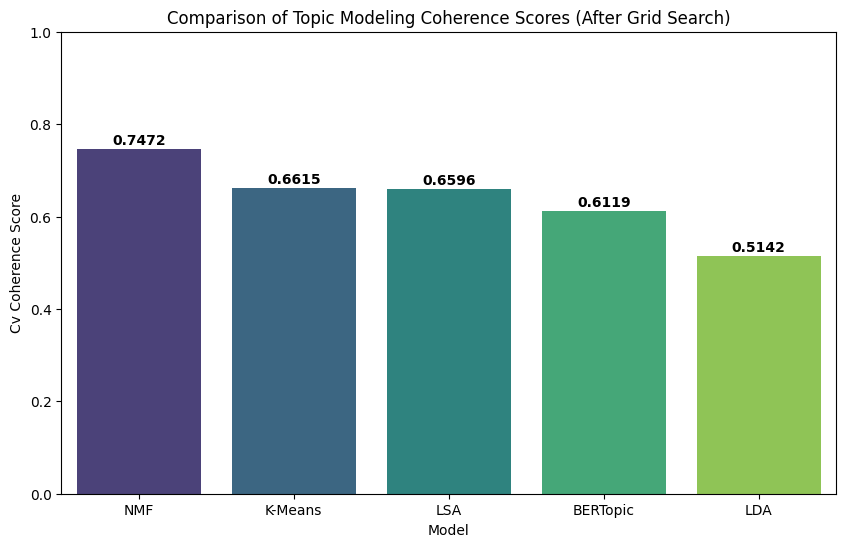


Topik dari Model Terbaik Keseluruhan (NMF):
Topic 0: economic, korea, south, gnu, investment, growth, global, cooperation, education, business
Topic 1: vaccine, trial, covid, research, candidate, clinical, mrna, production, phase, pharmaceutical
Topic 2: gilang, victim, sexual, police, fikris, thesis, wrapping, body, case, research
Topic 3: doctor, foreign, budi, medical, dismissal, plan, health, santoso, academic, freedom
Topic 4: test, lab, pcr, covid, sample, health, kit, virus, rapid, testing
Topic 5: political, attack, digital, social, government, election, cyberattacks, online, account, police
Topic 6: robot, patient, technology, hospital, medical, raisa, personnel, team, help, competition
Topic 7: museum, death, toetik, collection, funeral, aspect, culture, center, unique, human
Topic 8: combination, drug, trial, bpom, clinical, remedy, covid, medication, pandu, lopinavir


In [19]:
print("=== FINAL COMPARISON (After Grid Search) ===")
results_df_grid_search = pd.DataFrame(all_scores).sort_values(by='Coherence', ascending=False)

print("\n" + "="*40)
print("FINAL RESULTS (Ranked by Coherence Score after Grid Search)")
print(results_df_grid_search)
print("="*40)

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df_grid_search, x='Model', y='Coherence', palette='viridis')
plt.title('Comparison of Topic Modeling Coherence Scores (After Grid Search)')
plt.ylabel('Cv Coherence Score')
plt.ylim(0, 1.0)
for i, v in enumerate(results_df_grid_search['Coherence']):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold')
plt.show()

# --- PRINT TOP WORDS FOR OVERALL BEST MODEL ---
best_overall_model_name = results_df_grid_search.iloc[0]['Model']
print(f"\nTopik dari Model Terbaik Keseluruhan ({best_overall_model_name}):")

if best_overall_model_name == 'BERTopic':
    if best_model:
        print(best_model.get_topic_info().head(6)[['Topic', 'Count', 'Name', 'Representation']])
    else:
        print("BERTopic model not available.")
elif best_overall_model_name == 'K-Means':
    # Re-train K-Means with best_k_kmeans to get cluster assignments for display
    kmeans_best = KMeans(n_clusters=best_k_kmeans, random_state=42, n_init=10)
    clusters_best = kmeans_best.fit_predict(reduced_embeddings)

    kmeans_topic_words_best = []
    for i in range(best_k_kmeans):
        cluster_docs_indices = df.index[clusters_best == i]
        if len(cluster_docs_indices) == 0: continue
        cluster_docs_content = df.loc[cluster_docs_indices, 'clean_content']
        if len(cluster_docs_content) > 0:
            cluster_tfidf = tfidf_km.transform(cluster_docs_content)
            if cluster_tfidf.shape[0] > 0:
                mean_tfidf = np.array(cluster_tfidf.mean(axis=0)).flatten()
                n_top_words = min(10, len(features_km))
                top_indices = mean_tfidf.argsort()[:-n_top_words - 1:-1]
                kmeans_topic_words_best.append([features_km[ind] for ind in top_indices])
    for i, words in enumerate(kmeans_topic_words_best):
        print(f"Cluster {i}: {', '.join(words)}")
elif best_overall_model_name == 'NMF':
    if best_nmf_model_for_display:
        nmf_words_best = get_sklearn_topic_words(best_nmf_model_for_display, tfidf_feature_names, n_top_words=10)
        for i, words in enumerate(nmf_words_best):
            print(f"Topic {i}: {', '.join(words)}")
    else:
        print("NMF model not available.")
elif best_overall_model_name == 'LSA':
    if best_lsa_model_for_display:
        lsa_words_best = get_sklearn_topic_words(best_lsa_model_for_display, tfidf_feature_names, n_top_words=10)
        for i, words in enumerate(lsa_words_best):
            print(f"Topic {i}: {', '.join(words)}")
    else:
        print("LSA model not available.")
elif best_overall_model_name == 'LDA':
    if best_lda_model_for_display:
        lda_words_best = get_sklearn_topic_words(best_lda_model_for_display, tf_feature_names, n_top_words=10)
        for i, words in enumerate(lda_words_best):
            print(f"Topic {i}: {', '.join(words)}")
    else:
        print("LDA model not available.")

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Import pandas for DataFrame creation within the function

def plot_single_topic_words_bar_chart_on_ax(ax, words, scores, topic_title, n_top_words=10):
    """
    Generates a horizontal bar chart for topic words and their scores on a given axes.

    Args:
        ax (matplotlib.axes.Axes): The axes object to plot on.
        words (list): List of topic words.
        scores (list): List of corresponding scores/weights.
        topic_title (str): Title for the subplot.
        n_top_words (int): Number of top words to display.
    """
    # Ensure words and scores are valid and of equal length
    if not words or not scores or len(words) != len(scores):
        ax.set_title(f"{topic_title} (No words/scores available)")
        ax.axis('off') # Hide axes if no data
        return

    # Combine words and scores, sort by score, and take top N
    word_score_pairs = sorted(zip(words, scores), key=lambda x: x[1], reverse=True)[:n_top_words]
    plot_words = [pair[0] for pair in word_score_pairs]
    plot_scores = [pair[1] for pair in word_score_pairs]

    if not plot_words:
        ax.set_title(f"{topic_title} (No words to plot)")
        ax.axis('off') # Hide axes if no data
        return

    df_plot = pd.DataFrame({'Word': plot_words, 'Score': plot_scores})

    sns.barplot(x='Score', y='Word', data=df_plot, palette='viridis', ax=ax)
    ax.set_title(topic_title, fontsize=12)
    ax.set_xlabel('Score/Weight', fontsize=10)
    ax.set_ylabel('Word', fontsize=10)
    ax.invert_yaxis() # Display highest score at the top
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

print("Modified plot_single_topic_words_bar_chart_on_ax function.")

Modified plot_single_topic_words_bar_chart_on_ax function.



--- Visualizing Top Words with Scores for BERTopic (1 plot per model) ---


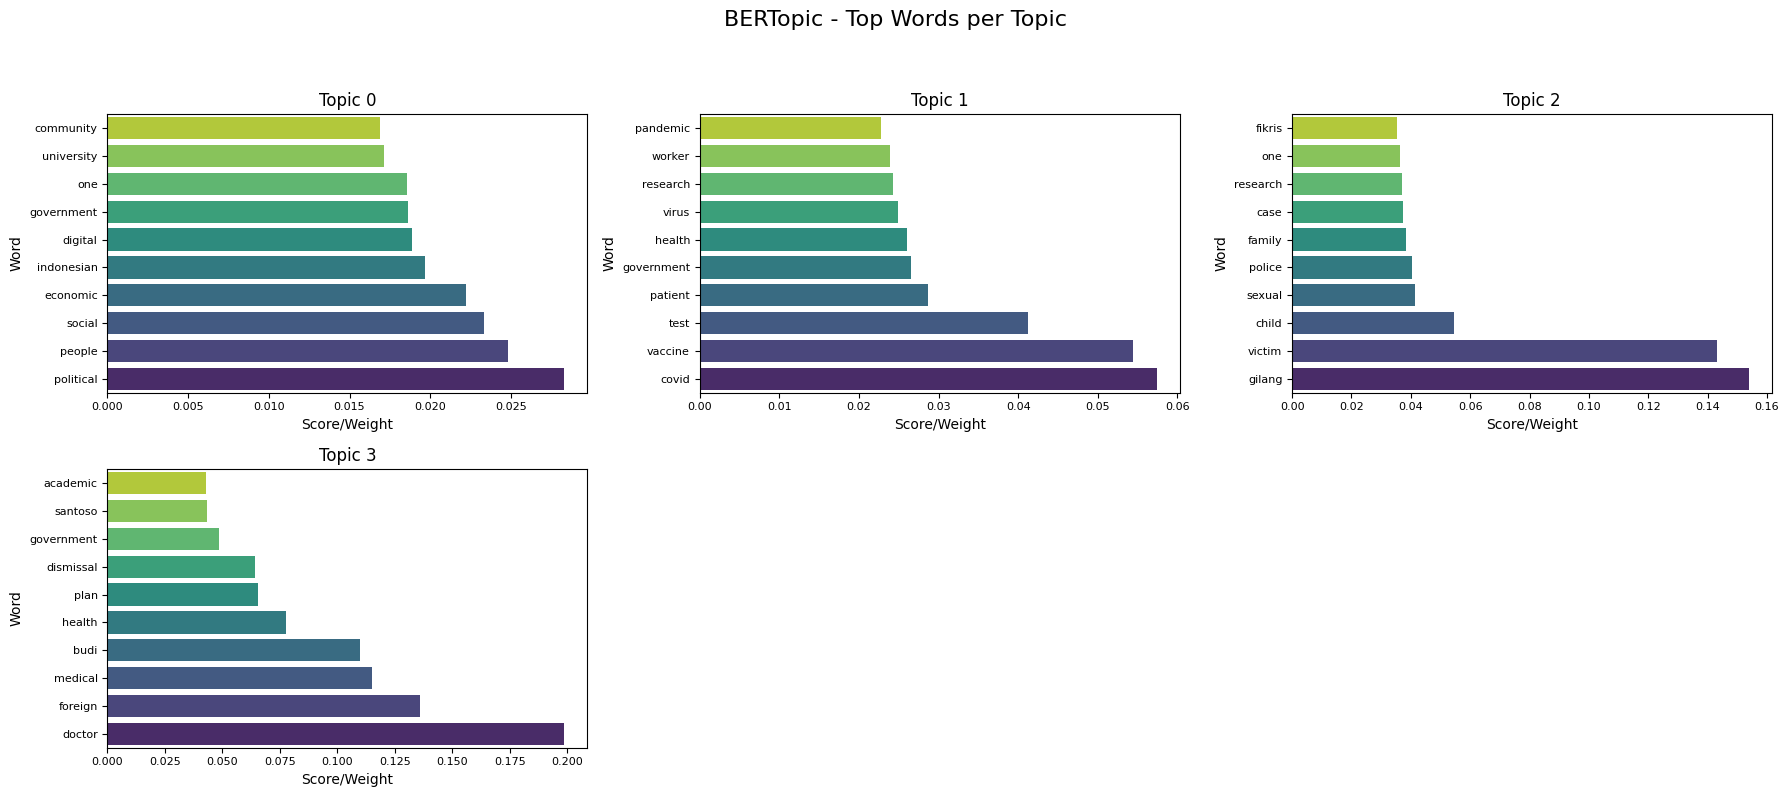

In [27]:
print("\n--- Visualizing Top Words with Scores for BERTopic (1 plot per model) ---")
if 'best_model' in locals() and best_model is not None:
    topic_info_bertopic = best_model.get_topic_info()
    # Filter out the outlier topic (-1)
    valid_topics_bertopic = topic_info_bertopic[topic_info_bertopic['Topic'] != -1]['Topic'].tolist()

    if valid_topics_bertopic:
        num_topics = len(valid_topics_bertopic)
        # Determine grid size. Max 3 columns, adjust rows dynamically.
        cols = min(3, num_topics)
        rows = (num_topics + cols - 1) // cols # Ceiling division
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4), squeeze=False)
        fig.suptitle('BERTopic - Top Words per Topic', fontsize=16, y=1.02) # Main title for the figure

        for i, topic_id in enumerate(valid_topics_bertopic):
            r, c = divmod(i, cols)
            ax = axes[r, c]
            words_and_scores = best_model.get_topic(topic_id) # Already returns (word, score) tuples
            words = [item[0] for item in words_and_scores]
            scores = [item[1] for item in words_and_scores]
            plot_single_topic_words_bar_chart_on_ax(ax, words, scores, f'Topic {topic_id}')

        # Hide any unused subplots
        for i in range(num_topics, rows * cols):
            r, c = divmod(i, cols)
            axes[r, c].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent title overlap
        plt.show()
    else:
        print("No valid BERTopic topics found to generate visualizations.")
elif 'best_score' in globals() and best_score == -1:
    print("BERTopic was run but no valid topics were found.")
else:
    print("BERTopic 'best_model' not found or not fully trained. Skipping visualization.")


--- Visualizing Top Words with Scores for K-Means (1 plot per model) ---


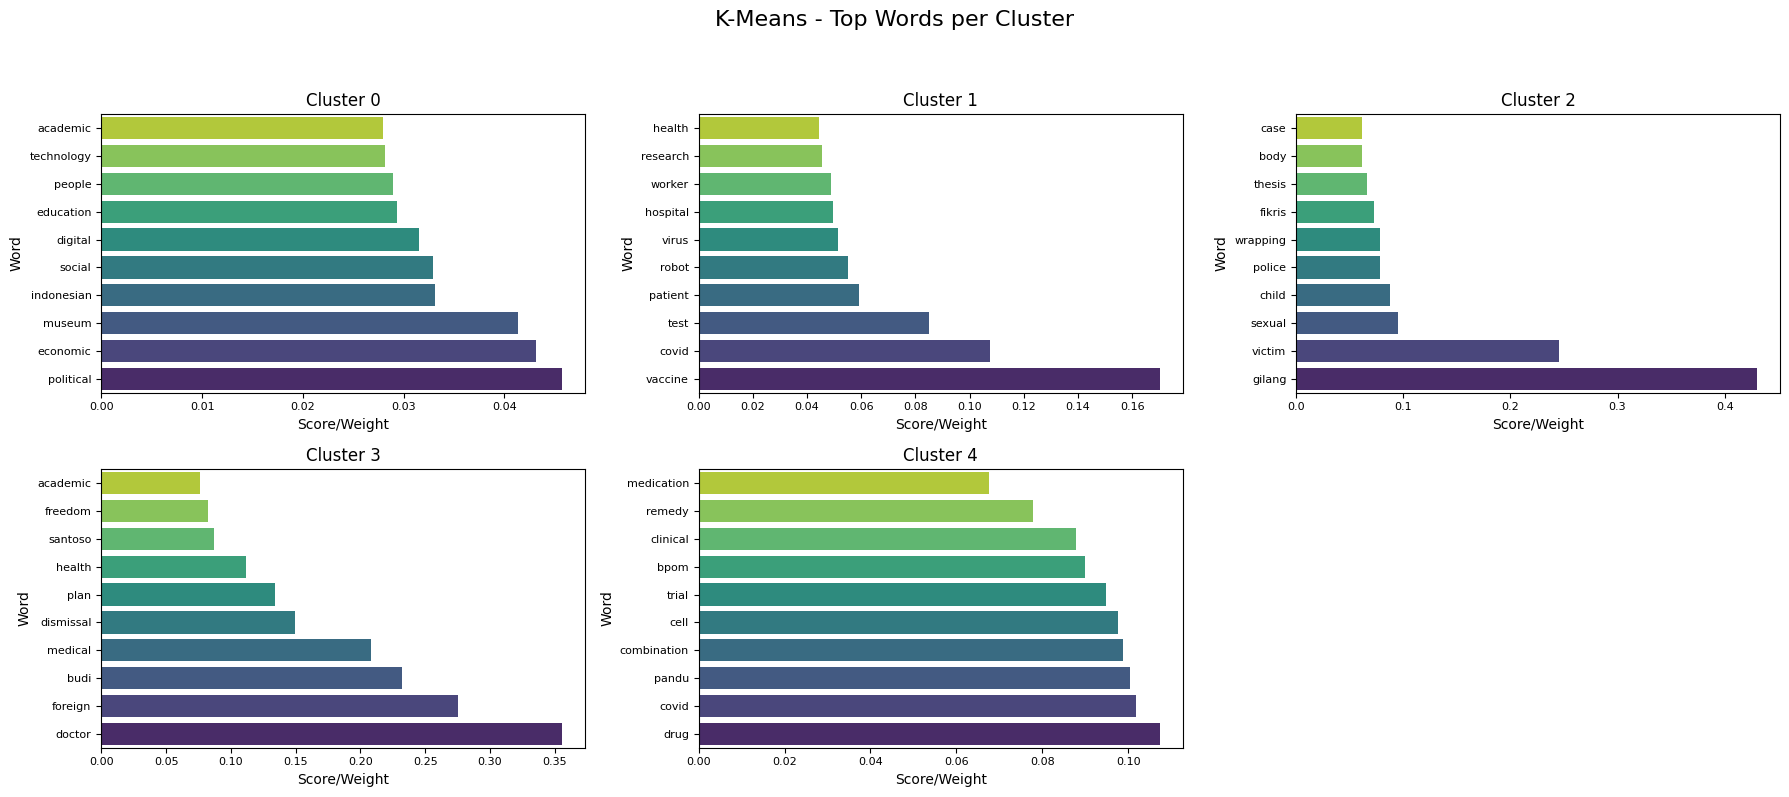

In [28]:
import numpy as np # Import numpy

print("\n--- Visualizing Top Words with Scores for K-Means (1 plot per model) ---")
if 'best_k_kmeans' in locals() and best_k_kmeans > 0 and \
   'reduced_embeddings' in locals() and 'tfidf_km' in locals() and 'features_km' in locals() and 'df' in locals():

    # Re-cluster with the best k
    kmeans_best = KMeans(n_clusters=best_k_kmeans, random_state=42, n_init=10)
    clusters_best = kmeans_best.fit_predict(reduced_embeddings)

    kmeans_topic_words_with_scores_list = []
    for i in range(best_k_kmeans):
        cluster_docs_indices = df.index[clusters_best == i]
        if len(cluster_docs_indices) == 0:
            kmeans_topic_words_with_scores_list.append([]) # Append empty list for this cluster
            continue
        cluster_docs_content = df.loc[cluster_docs_indices, 'clean_content']

        if len(cluster_docs_content) > 0:
            cluster_tfidf = tfidf_km.transform(cluster_docs_content)
            if cluster_tfidf.shape[0] > 0:
                mean_tfidf = np.array(cluster_tfidf.mean(axis=0)).flatten()
                n_words_to_extract = min(10, len(features_km))
                top_indices_scores = mean_tfidf.argsort()[-n_words_to_extract:][::-1]

                words_with_scores = [(features_km[idx], mean_tfidf[idx]) for idx in top_indices_scores]
                kmeans_topic_words_with_scores_list.append(words_with_scores)
            else:
                kmeans_topic_words_with_scores_list.append([])
        else:
            kmeans_topic_words_with_scores_list.append([])

    num_topics = best_k_kmeans
    cols = min(3, num_topics)
    rows = (num_topics + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4), squeeze=False)
    fig.suptitle('K-Means - Top Words per Cluster', fontsize=16, y=1.02)

    for i in range(num_topics):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        words_and_scores = kmeans_topic_words_with_scores_list[i]
        words = [item[0] for item in words_and_scores]
        scores = [item[1] for item in words_and_scores]
        plot_single_topic_words_bar_chart_on_ax(ax, words, scores, f'Cluster {i}')

    for i in range(num_topics, rows * cols):
        r, c = divmod(i, cols)
        axes[r, c].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()
else:
    print("K-Means best model or necessary data not found. Skipping visualization.")


--- Visualizing Top Words with Scores for NMF (1 plot per model) ---


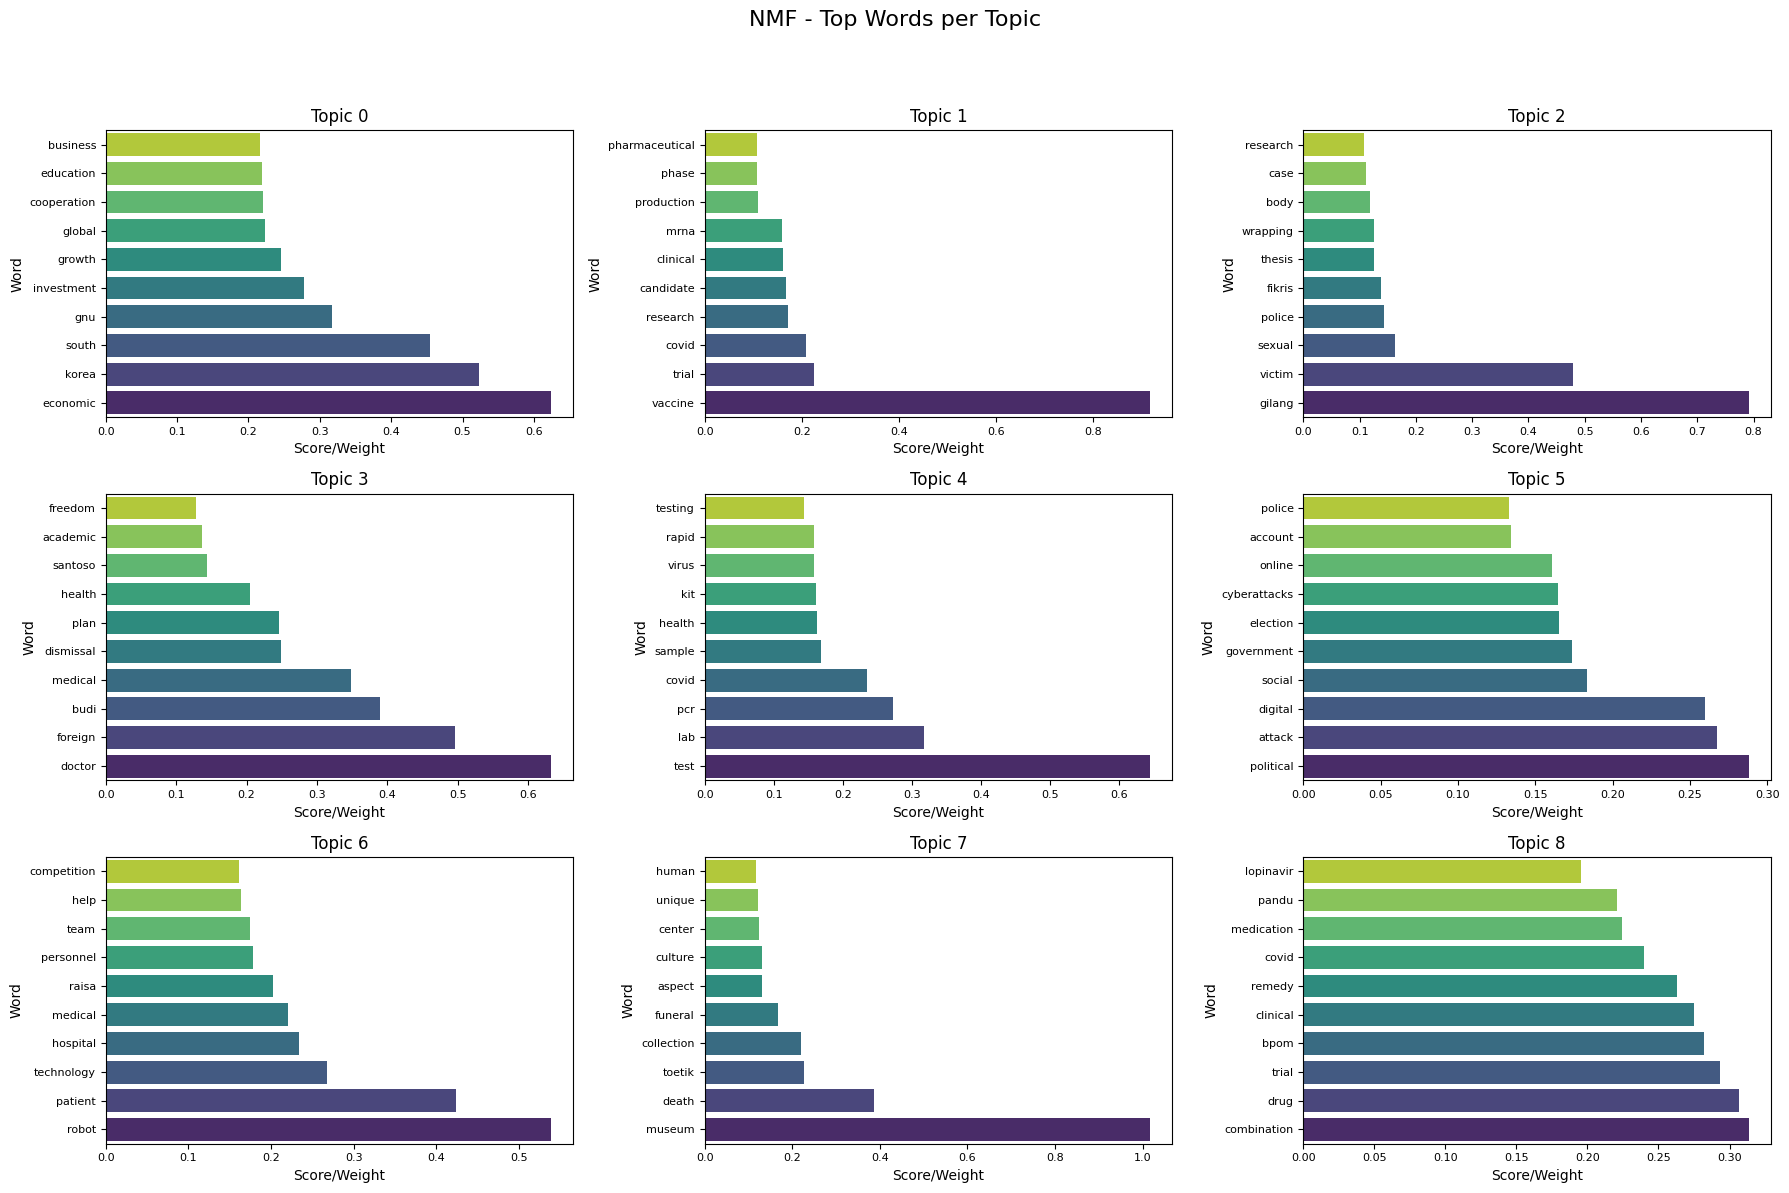

In [29]:
print("\n--- Visualizing Top Words with Scores for NMF (1 plot per model) ---")
if 'best_nmf_model_for_display' in locals() and best_nmf_model_for_display is not None and 'tfidf_feature_names' in locals():
    num_topics = best_nmf_model_for_display.n_components
    cols = min(3, num_topics)
    rows = (num_topics + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4), squeeze=False)
    fig.suptitle('NMF - Top Words per Topic', fontsize=16, y=1.02)

    for i, topic_components in enumerate(best_nmf_model_for_display.components_):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        n_words_to_extract = min(10, len(tfidf_feature_names))
        top_indices = topic_components.argsort()[-n_words_to_extract:][::-1] # Top 10 indices

        words = [tfidf_feature_names[idx] for idx in top_indices]
        scores = [topic_components[idx] for idx in top_indices]

        plot_single_topic_words_bar_chart_on_ax(ax, words, scores, f'Topic {i}')

    for i in range(num_topics, rows * cols):
        r, c = divmod(i, cols)
        axes[r, c].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()
else:
    print("NMF best model or necessary data not found. Skipping visualization.")


--- Visualizing Top Words with Scores for LSA (1 plot per model) ---


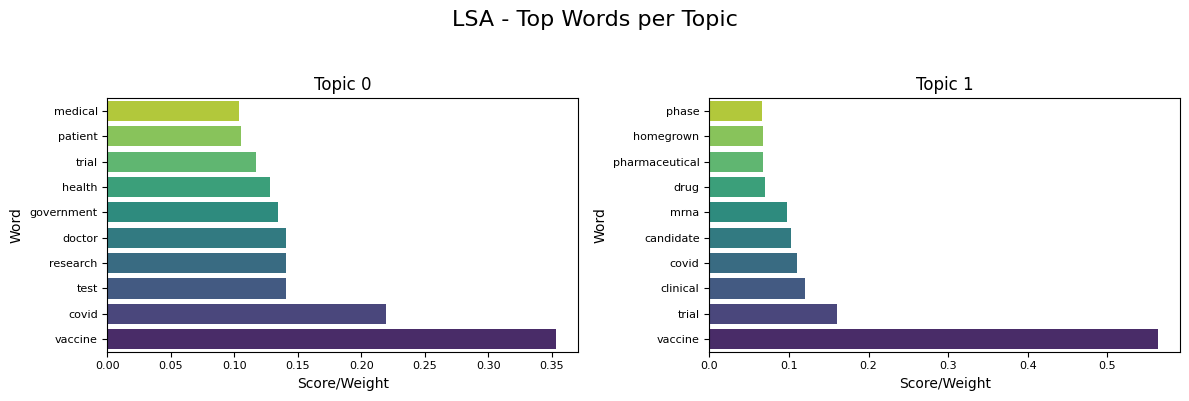

In [30]:
print("\n--- Visualizing Top Words with Scores for LSA (1 plot per model) ---")
if 'best_lsa_model_for_display' in locals() and best_lsa_model_for_display is not None and 'tfidf_feature_names' in locals():
    num_topics = best_lsa_model_for_display.n_components
    cols = min(3, num_topics)
    rows = (num_topics + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4), squeeze=False)
    fig.suptitle('LSA - Top Words per Topic', fontsize=16, y=1.02)

    for i, topic_components in enumerate(best_lsa_model_for_display.components_):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        n_words_to_extract = min(10, len(tfidf_feature_names))
        top_indices = topic_components.argsort()[-n_words_to_extract:][::-1] # Top 10 indices

        words = [tfidf_feature_names[idx] for idx in top_indices]
        scores = [topic_components[idx] for idx in top_indices]

        plot_single_topic_words_bar_chart_on_ax(ax, words, scores, f'Topic {i}')

    for i in range(num_topics, rows * cols):
        r, c = divmod(i, cols)
        axes[r, c].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()
else:
    print("LSA best model or necessary data not found. Skipping visualization.")


--- Visualizing Top Words with Scores for LDA (1 plot per model) ---


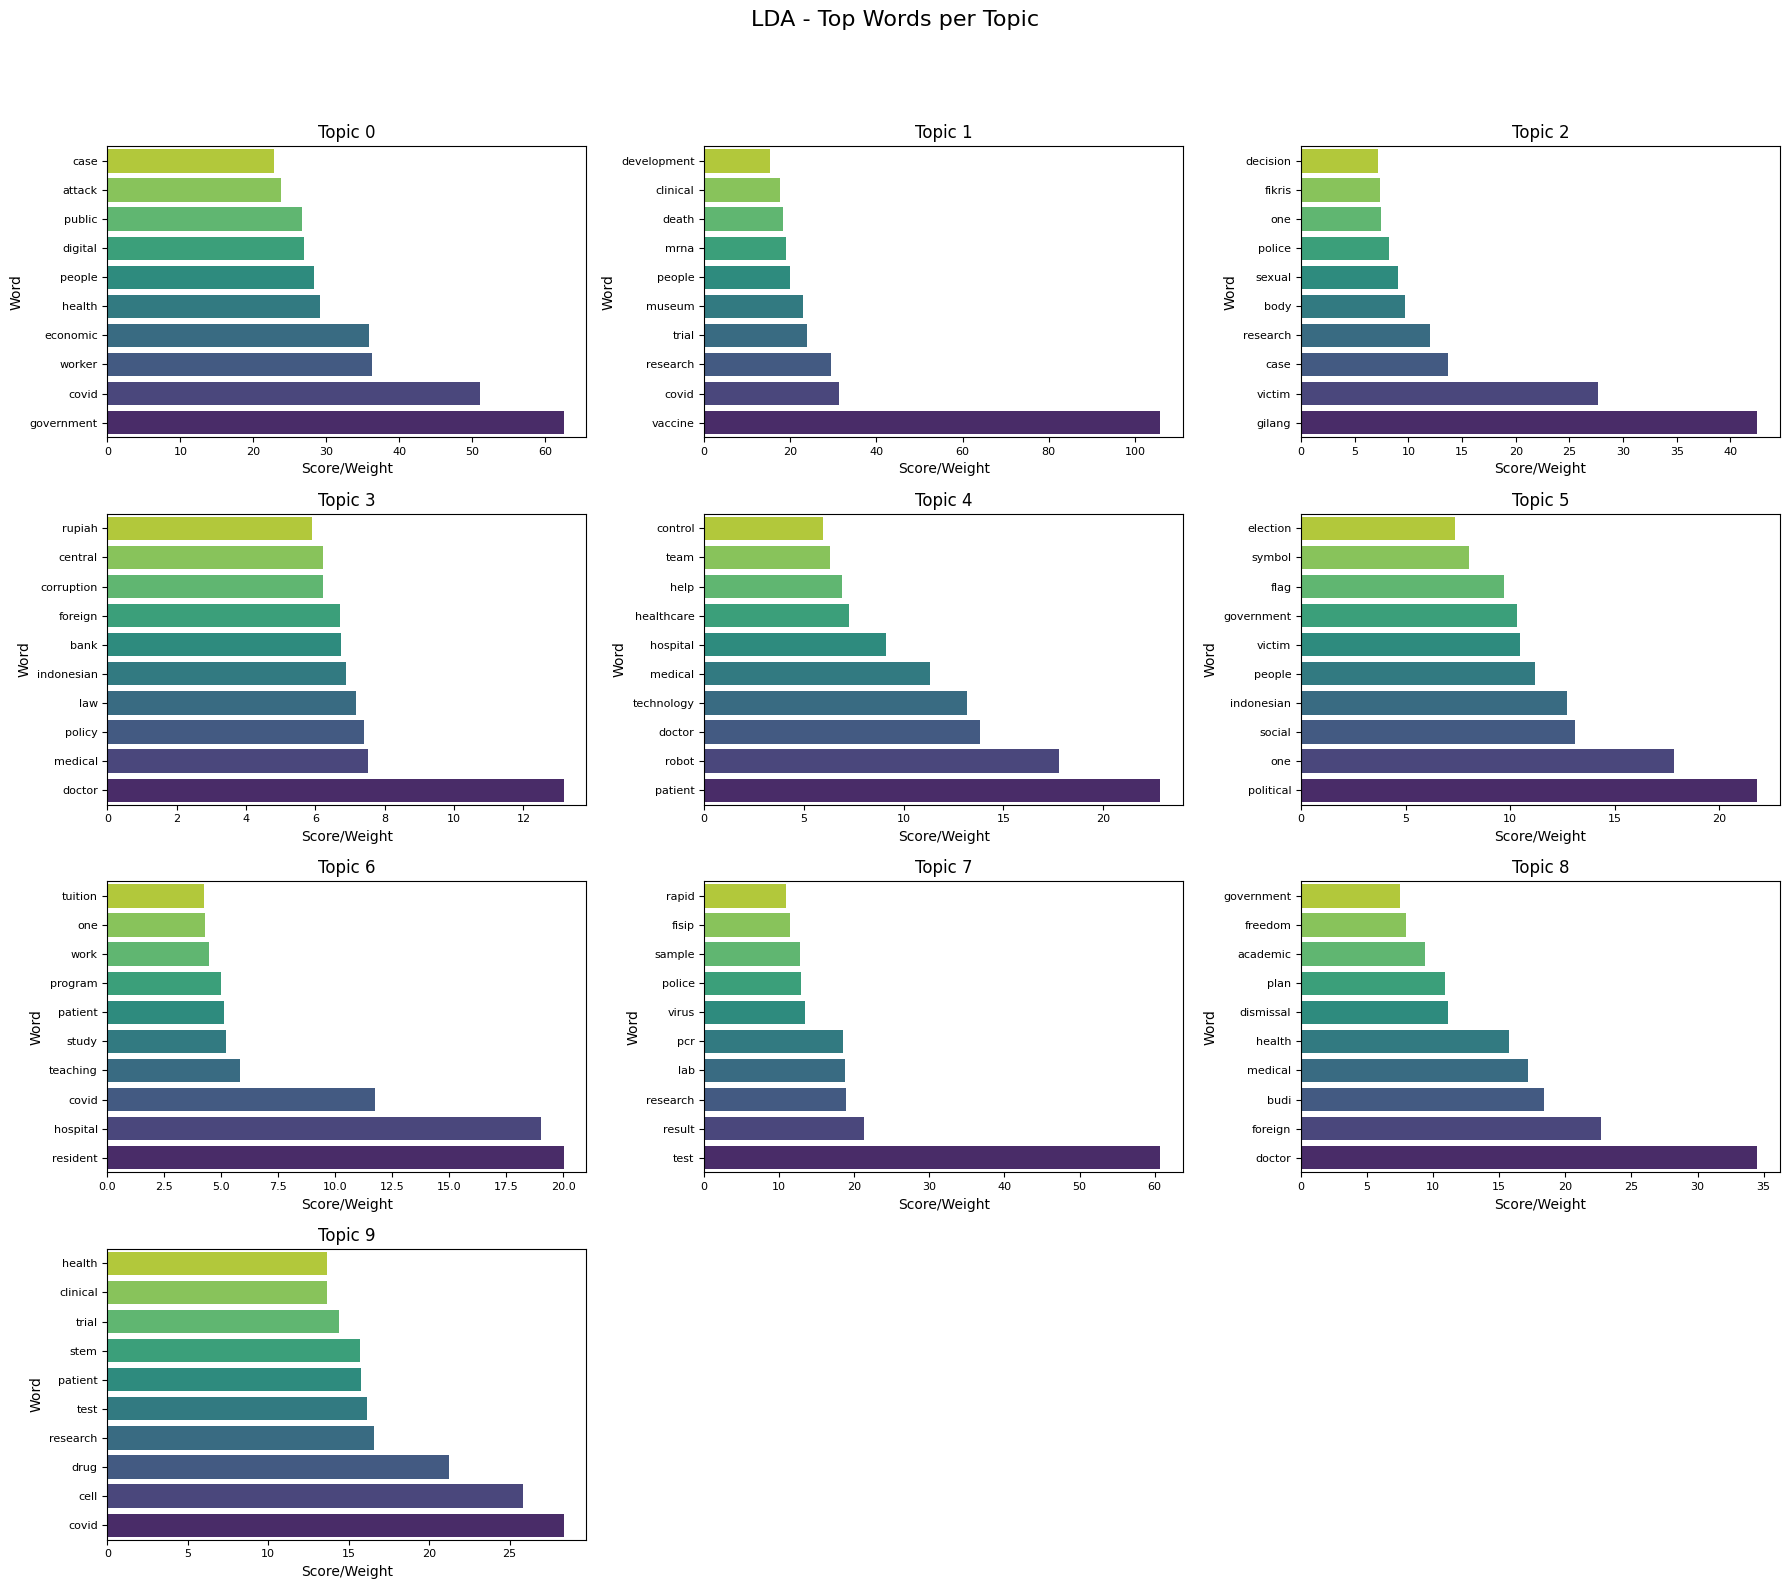

In [31]:
print("\n--- Visualizing Top Words with Scores for LDA (1 plot per model) ---")
if 'best_lda_model_for_display' in locals() and best_lda_model_for_display is not None and 'tf_feature_names' in locals():
    num_topics = best_lda_model_for_display.n_components
    cols = min(3, num_topics)
    rows = (num_topics + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4), squeeze=False)
    fig.suptitle('LDA - Top Words per Topic', fontsize=16, y=1.02)

    for i, topic_components in enumerate(best_lda_model_for_display.components_):
        r, c = divmod(i, cols)
        ax = axes[r, c]
        n_words_to_extract = min(10, len(tf_feature_names))
        top_indices = topic_components.argsort()[-n_words_to_extract:][::-1] # Top 10 indices

        words = [tf_feature_names[idx] for idx in top_indices]
        scores = [topic_components[idx] for idx in top_indices]

        plot_single_topic_words_bar_chart_on_ax(ax, words, scores, f'Topic {i}')

    for i in range(num_topics, rows * cols):
        r, c = divmod(i, cols)
        axes[r, c].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()
else:
    print("LDA best model or necessary data not found. Skipping visualization.")